# Compare Temperature and Salinity from ACCESS-OM2 to WOA13

This notebook shows examples of comparing ACCESS-OM2 Temperature and Salinity structure to the WOA13 climatology (that is used as initial conditions for most runs). We describe the location and setup of the WOA13 data interpolated onto the model grids, as well as plot SST and SSS anomalies along with equatorial slices of temperature and salinity anomalies.

First, lets load in some modules, call some workers and load a database

In [3]:
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings

import cosima_cookbook as cc

from dask.distributed import Client

In [4]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34819 Dashboard: /proxy/34545/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


In [6]:
session = cc.database.create_session()

## WOA13 data

The WOA13 data has already been interpolated onto the various model grids (as it is used for initial conditions). This makes it easy to plot biases.

The WOA13 data is located in the `/g/data/hh5/tmp/cosima/woa13/` folder, with various subfolders for the different resolutions (including the different vertical grids such as KDS50, KDS75 etc.). The available interpolated versions are (see `/g/data/hh5/tmp/cosima/woa13/README/`:

- `woa13/10` - 1-degree, GFDL50 vertical levels scheme
- `woa13/025` - 1/4-degree, GFDL50 vertical levels scheme
- `woa13/01` - 1/10-degree, KDS75 vertical levels scheme
- `woa13/10_KDS50` - 1-degree, KDS50 vertical levels scheme
- `woa13/025_KDS50` - 1/4-degree, KDS50 vertical levels scheme

Note that the new ACCESS-OM2 runs all use the KDS vertical levels schemes (KDS50 at 1-degree and 1/4-degree, KDS75 at 1/10-degree).

Let's first explore some of this data by looking at the 1-degree KDS50 experiment. First the netcdf files. Note that currently, because of the folder structure of the WOA13 data, the experiment names can be a bit opaque as they do not contain the woa13 string. Here we examine the 1-degree KDS50 data

In [7]:
cc.querying.get_ncfiles(session,experiment='10_KDS50')

,ncfile,index_time
0,output000/ocean_temp_salt.res.nc,2020-03-26 21:09:37.542677
1,output000/woa13_ts_01_mom10.nc,2020-03-26 21:09:38.100254
2,output000/woa13_ts_02_mom10.nc,2020-03-26 21:09:37.846358
3,output000/woa13_ts_03_mom10.nc,2020-03-26 21:09:38.478758
4,output000/woa13_ts_04_mom10.nc,2020-03-26 21:09:38.827761
5,output000/woa13_ts_05_mom10.nc,2020-03-26 21:09:38.573632
6,output000/woa13_ts_06_mom10.nc,2020-03-26 21:09:37.709716
7,output000/woa13_ts_07_mom10.nc,2020-03-26 21:09:38.241057
8,output000/woa13_ts_08_mom10.nc,2020-03-26 21:09:38.347195
9,output000/woa13_ts_09_mom10.nc,2020-03-26 21:09:38.127700


The `ocean_temp_salt.res.nc` is the initial conditions file - we don't want to use this for plotting. Finally, the variables:

In [8]:
cc.querying.get_variables(session,experiment='10_KDS50')

,name,frequency,ncfile,# ncfiles,time_start,time_end
0,GRID_X_T,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00
1,GRID_Y_T,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00
2,ZT,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00
3,salt,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00
4,temp,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00
5,time,static,output000/woa13_ts_12_mom10.nc,13,0001-01-02 00:00:00,0001-01-13 00:00:00


## Comparing to ACCESS-OM2 simulations

Now lets plot some biases against the WOA13 data set. We will use the original ACCESS-OM2 IAF runs, so first define a dictionary with information on those runs

In [11]:
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF', # 1deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2 IAF', 'expt': '1deg_jra55v13_iaf_spinup1_B1',
      'n_files': -12, 'itime': '1998-01-01', 'ftime': None}),
    ('025degIAF', # 025deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2-025 IAF', 'expt': '025deg_jra55v13_iaf_gmredi6',
      'n_files': -34, 'itime': '1998-01-01', 'ftime': None}),
    ('01degIAF', # 01deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2-01 IAF',  'expt': '01deg_jra55v13_iaf',
      'n_files': None, 'itime': '1998-01-01','ftime': None})
])

For each of these runs we then attach information to these dictionaries containing the matched WOA13 interpolated data sets. Note that we include a file name (with wildcards) so that we only use the monthly files and not the additional `ocean_temp_salt.res.nc` initial condition file.

In [12]:
# Add on pre-interpolated WOA13 directories for every run:
for ekey in exptdict.keys():
    e = exptdict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

## SST and SSS biases

We will start by plotting SST and SSS biases compared to WOA13. The following loop loads data from the model runs and the corresponding WOA13 data and saves them into the previous dictionary (as entries SST, SST_WOA13 and SST_anom and the same for SSS). This can take time...

In [13]:
# Function to extract and load SST and SSS from the models, WOA13
ekeys = ['1degIAF', '025degIAF', '01degIAF']
for ekey in ekeys:
    e = exptdict[ekey]
    
    # SST
    # -----
    
    # Load surface temperature from model
    surface_temp = cc.querying.getvar(e['expt'], 'temp', session,
                            n=e['n_files'], ncfile='ocean.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)
    
    # Extract a year range string and print (for title string):
    e['yearrange'] = "{} to {}".format(
        surface_temp.time.item(0).strftime("%Y-%m"),
        surface_temp.time.item(-1).strftime("%Y-%m"),
    )
    print(f"{ekey}: {e['yearrange']}")
    
    # Add SST to dictionary
    e['SST'] = surface_temp.mean('time').load() - 273.15
    
    # Load WOA13 SST and add to dictionary
    # ignore warning about ambiguous files
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SST_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session).isel(ZT=0).mean('time').load()
    
    # Calculate bias and add to dictionary
    SST_anom = e['SST'] - e['SST_WOA13'].values 
    e['SST_anom'] = SST_anom.load()
    
    # SSS
    # -----
    surface_salt = cc.querying.getvar(e['expt'], 'salt', session,
                            n=e['n_files'],ncfile='ocean.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)
    e['SSS'] = surface_salt.mean('time').load()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SSS_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt',session).isel(ZT=0).mean('time').load()
    SSS_anom = e['SSS'] - e['SSS_WOA13'].values 
    e['SSS_anom'] = SSS_anom.load()

1degIAF: 2198-07 to 2257-07
025degIAF: 2198-06 to 2257-06
01degIAF: 1998-01 to 2017-12


Now that all the data is loaded, all we have to do is plot it.

We first define a function to plot the SST

In [14]:
def plot_SST(ekeys):
    clev = np.arange(-3,3.25,0.25)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='gray', linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SST_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev, add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        
        if i == 1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['01degIAF']
    ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SST_WOA13'].plot.contourf(cmap=cm.cm.thermal,levels=np.arange(-2.,32.,1.),add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92,0.52,0.01,0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SST anomaly (°C)')

    ax6 = plt.axes([0.92,0.13,0.01,0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SST (°C)')

and then we plot it

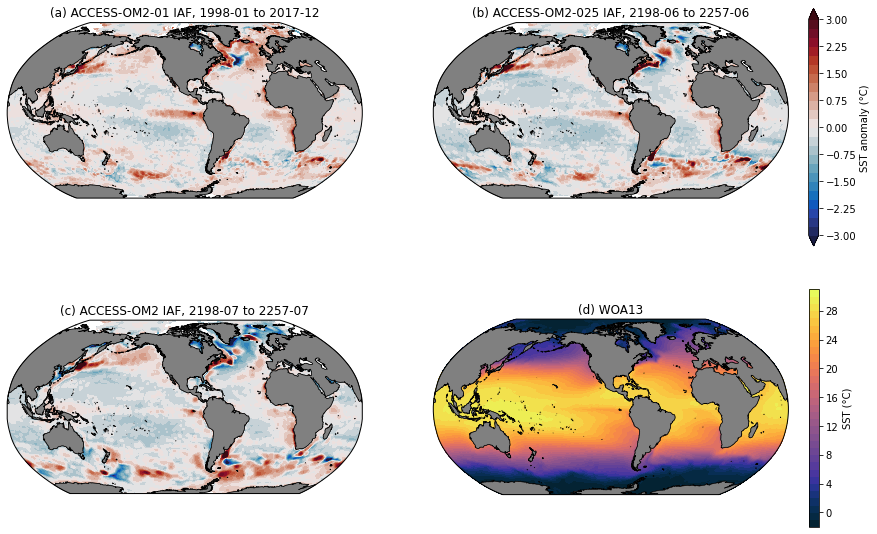

In [15]:
# Plot IAF and RYF SST biases at 3 resolutions:
fig = plt.figure(figsize=(14, 10))
ekeys = ['01degIAF', '025degIAF', '1degIAF']
plot_SST(ekeys)
#savefigure('SST_bias_IAF_RYF')

Then we do the same for sea surface salinity biases

In [16]:
def plot_SSS(ekeys):
    clev = np.arange(-1.5, 1.6, 0.1)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='gray',linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SSS_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev, add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        
        if i == 1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['01degIAF']
    ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SSS_WOA13'].plot.contourf(cmap=cm.cm.thermal, levels=np.arange(31., 36.2, 0.2), add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92, 0.52, 0.01, 0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SSS anomaly (psu)')

    ax6 = plt.axes([0.92, 0.13, 0.01, 0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SSS (psu)')

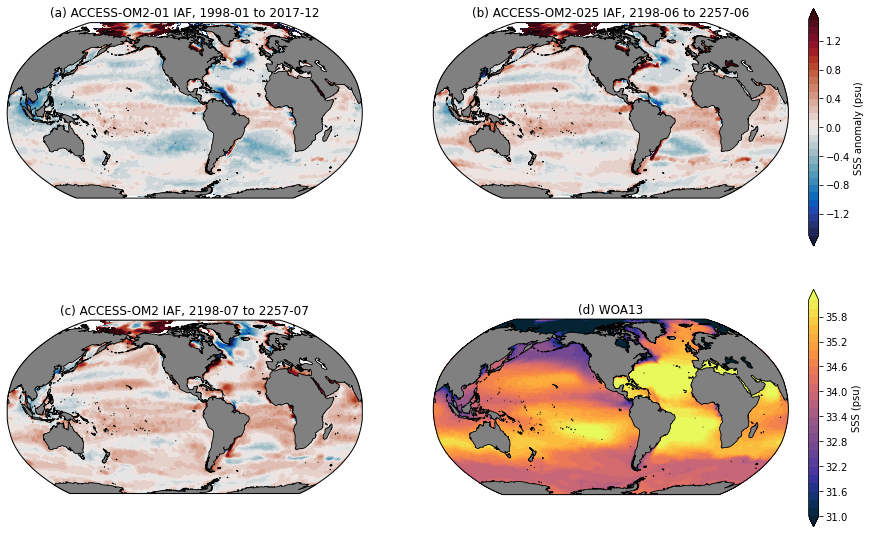

In [17]:
# Plot IAF and RYF SSS biases at 3 resolutions:
fig = plt.figure(figsize=(14, 10))
ekeys = ['01degIAF', '025degIAF', '1degIAF']
plot_SSS(ekeys)
#savefigure('SSS_bias_IAF_RYF')

## Equatorial Pacific Temperature and Salinity Longitude-depth biases

Our final example compares temperature and salinity biases in the tropical Pacific (note, this overlaps somewhat with the `Equatorial_thermal_and_zonal_velocity_structure.ipynb` documented example).

We follow the same procedure as before, first loading the data.

In [18]:
# Define list of experiments to load (useful for testing):
ekeys = ['1degIAF', '025degIAF', '01degIAF']

# Loop through models
for ekey in ekeys:
    e = exptdict[ekey]
    
    # Load temperature
    eq_temp = cc.querying.getvar(e['expt'], 'temp',session,
                 n=e['n_files'], ncfile='ocean.nc',
                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0, method='nearest')
    
    # Set a text string to add the year range in title.
    e['yearrange'] = "{} to {}".format(
        eq_temp.time.item(0).strftime("%Y-%m"),
        eq_temp.time.item(-1).strftime("%Y-%m"),
    )
    print(f"{ekey}: {e['yearrange']}")
    
    # Extract the WOA13 data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_temp_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session).sel(GRID_Y_T=0., method='nearest').mean('time')
    
    # Calculate the bias
    eq_temp_anom = eq_temp.mean('time') - 273.15 - e['eq_temp_WOA13'].values
    eq_temp_anom.attrs['units'] = 'degrees Celsius'
    
    e['eq_temp_anom'] = eq_temp_anom.load()
    
    # Do salt as for temperature above
    eq_salt = cc.querying.getvar(e['expt'], 'salt',session,
                 n=e['n_files'], ncfile='ocean.nc',
                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0,method='nearest')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_salt_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt',session).sel(GRID_Y_T=0.,method='nearest').mean('time')
    eq_salt_anom = eq_salt.mean('time') - e['eq_salt_WOA13'].values
    e['eq_salt_anom'] = eq_salt_anom.load()

1degIAF: 2198-07 to 2257-07
025degIAF: 2198-06 to 2257-06
01degIAF: 1998-01 to 2017-12


Then plotting equatorial plots of temperature biases

In [19]:
# Define a function to plot Equatorial Slices of temperature:
def plot_eqtemp(ekeys):
    
    # Define contour levels
    clev = np.arange(-3.,3.25,0.25)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)
        
        # Plot bias as color
        pn = e['eq_temp_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)
        
        # Plot WOA13 isotherms (and 20C bold)
        CS = e['eq_temp_WOA13'].plot.contour(levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        e['eq_temp_WOA13'].plot.contour(levels=[20.], colors='k', linewidths=3.)
        (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.], colors='k', linewidths=3., linestyles='--')
        
        # Add annotations
        plt.title("({}) {},  {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isotherms', fontsize=15)
            p0 = pn

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

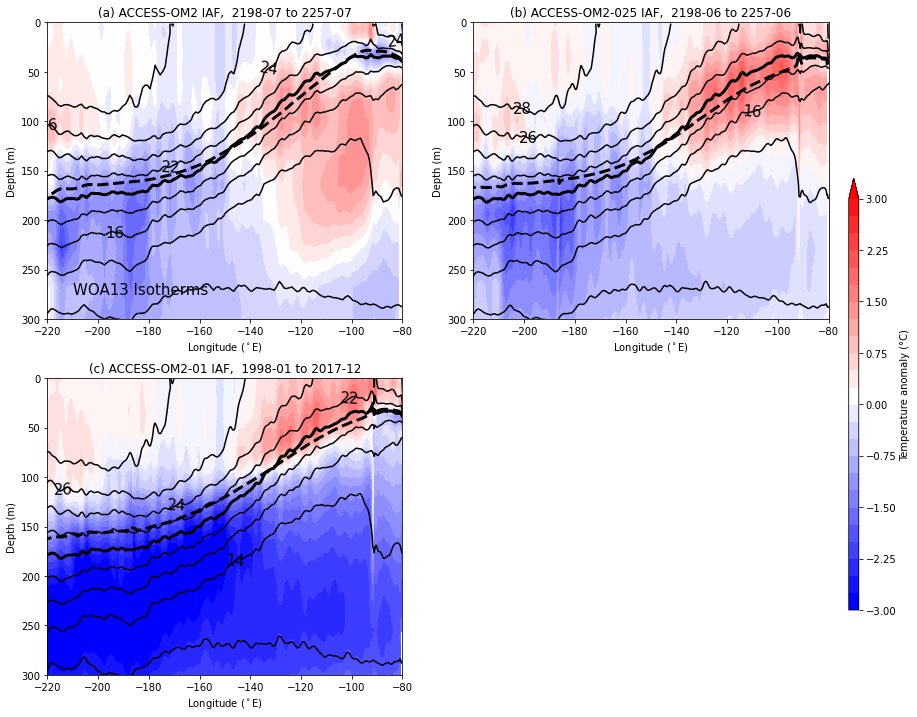

In [20]:
# Plot comparison of IAF simulations for temperature
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqtemp(ekeys)

And finally the same thing for salinity

In [21]:
# Define a function to plot Equatorial Slices of salinity
def plot_eqsalt(ekeys):
    
    # Define contour levels
    clev = np.arange(-1., 1.1, 0.1)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)
        
        # Plot bias as color
        pn = e['eq_salt_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)
        
        # Plot WOA13 salinity (and 20C bold)
        CS = e['eq_salt_WOA13'].plot.contour(levels=np.arange(30., 36.1, 0.1), colors='k')
        ax1.clabel(CS, inline=False, fmt='%3.2f', fontsize=15)
        
        # Add annotations
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300.,0.])
        ax1.set_xlim([-220.,-80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isohalines', fontsize=15)
            p0 = pn

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Salinity anomaly (psu)')

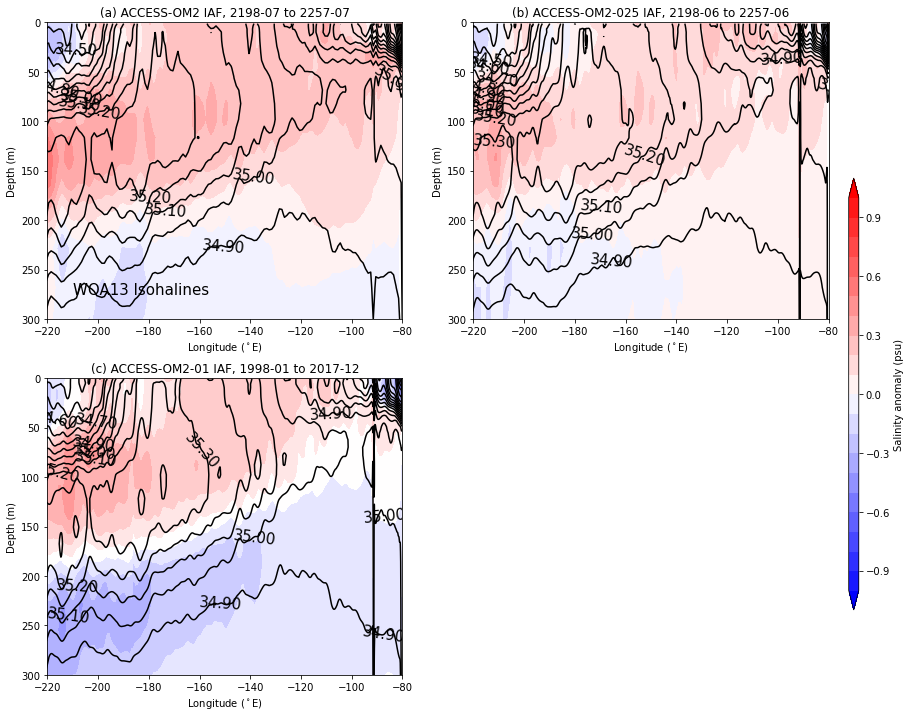

In [22]:
# Plot comparing IAF simulations for salinity
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqsalt(ekeys)